# Metodología

1. Se crean los datos sinteticos para el entrenamiento con el siguiente contexto:

Escenario clínico donde analizamos distintas variables asociadas a la presencia de una infección viral. Queremos inferir posibles relaciones causales entre las siguientes variables:

- **InfecciónViral**: variable binaria que indica si el paciente tiene una infección viral (1 = sí, 0 = no).
- **Estrés**: nivel de estrés percibido por el paciente, en una escala de 0 a 10.
- **TemperaturaCorporal**: medida de temperatura en °C.
- **DolorCabeza**: intensidad del dolor de cabeza (escala de 0 a 10).
- **ResultadoPCR**: resultado de la prueba PCR (1 = positivo, 0 = negativo).

### Variables y relaciones causales

- **InfecciónViral** ~ Binomial(0.4)  
  Variable binaria que representa la presencia de una infección viral.

- **Estrés** ~ Uniforme(0, 10)  
  Nivel de estrés percibido por el paciente.

- **TemperaturaCorporal** ← InfecciónViral  
  La fiebre es común en infecciones virales.

- **DolorCabeza** ← InfecciónViral, Estrés  
  Ambos factores pueden contribuir al dolor de cabeza, siendo el estrés un importante segundo factor.

- **ResultadoPCR** ← InfecciónViral  
  La prueba PCR depende directamente de la presencia o ausencia de la infección, con cierta probabilidad de error.
  2. Se visualizan los datos


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools

### ==== Creación de los datos ==== ###

np.random.seed(42)
n = 1000  # número de pacientes

# Variables raíz
infeccion = np.random.binomial(1, 0.4, size=n)
estres = np.random.randint(0, 10, size=n)

# Variables causadas
temperatura = 36.5 + 1.5 * infeccion + np.random.normal(0, 0.3, size=n)
dolor_cabeza = (2 + 1.0 * infeccion + 0.5 * estres + np.random.normal(0, 1, size=n)).astype(int)
resultado_pcr = np.random.binomial(1, 0.9 * infeccion + 0.1 * (1 - infeccion))

# Construir DataFrame
df = pd.DataFrame({
    'InfeccionViral': infeccion,
    'Estres': estres,
    'TemperaturaCorporal': temperatura,
    'DolorCabeza': dolor_cabeza,
    'ResultadoPCR': resultado_pcr
})

df.head()

InfeccionViral  Estres  TemperaturaCorporal  DolorCabeza  ResultadoPCR
0               0       7            36.259252            6             0
1               1       2            38.389643            5             1
2               1       7            37.705725            4             0
3               0       4            36.101625            4             0
4               0       0            36.704080            2             0

# Visualización de los datos


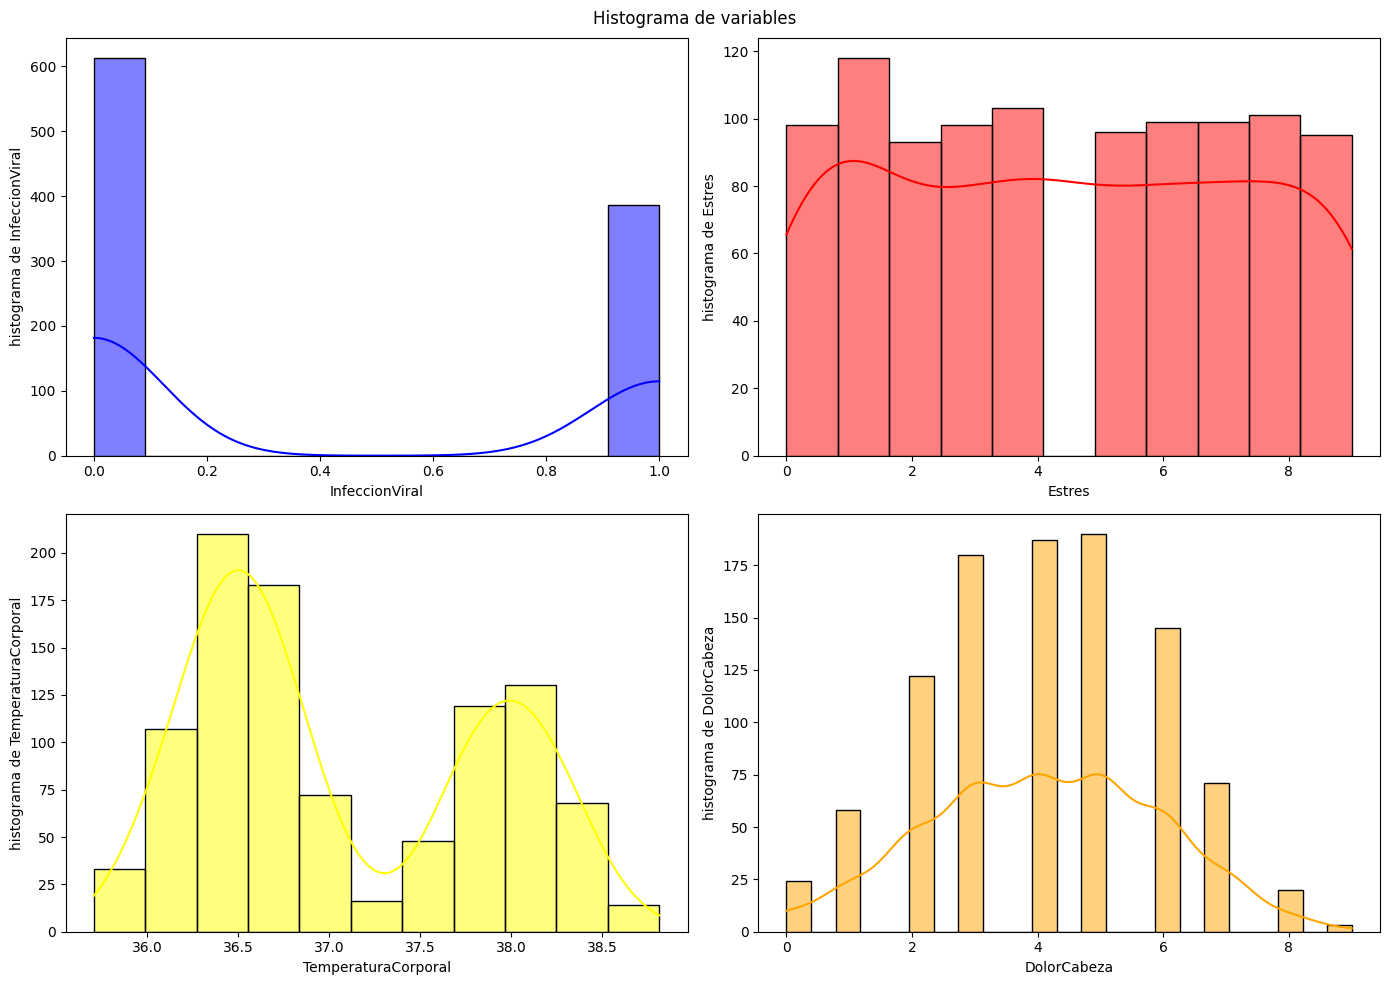

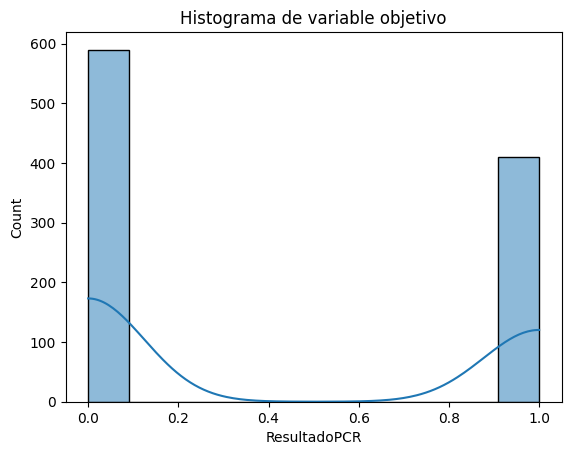

In [ ]:
variables = ['InfeccionViral', 'Estres', 'TemperaturaCorporal', 'DolorCabeza', 'ResultadoPCR']
color = ['blue','red','yellow','orange']

fig, ax  = plt.subplots(2,2,figsize=(14,10))
i = 0
for k in range(len(variables)-1):
  if k <= 1:
    sns.histplot( df[variables[k]], ax = ax[i,k], color = color[k], kde = True)
    ax[i,k].set_xlabel(variables[k])
    ax[i,k].set_ylabel(f'histograma de {variables[k]}')
  elif k > 1:
    sns.histplot( df[variables[k]], ax = ax[1,k-2], color = color[k], kde = True)
    ax[1,k-2].set_xlabel(variables[k])
    ax[1,k-2].set_ylabel(f'histograma de {variables[k]}')

fig.suptitle('Histograma de variables')
plt.tight_layout()
plt.savefig('histograma.png')
plt.show()
plt.close()


sns.histplot(df[variables[-1]], kde = True)
plt.xlabel(variables[-1])
plt.title('Histograma de variable objetivo')
plt.show()
plt.close()

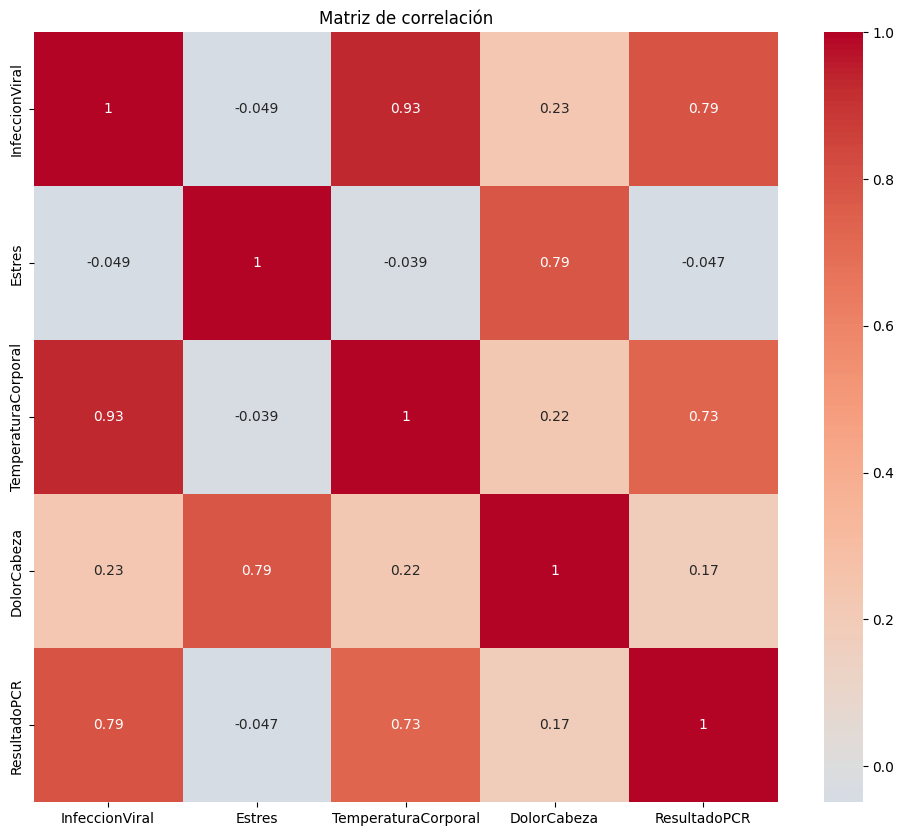

In [ ]:
### Matriz de correlación

correlacion = df.corr()
plt.figure(figsize=(12,10))
plt.title('Matriz de correlación')
sns.heatmap(correlacion, annot = True, cmap = "coolwarm", center=0)
plt.savefig('matriz_correlacion.png')
plt.show()

In [ ]:
# Visualización de la relación causal impuesta.

# Creación del grafo

G_ = nx.DiGraph()
G_.add_nodes_from(variables)
G_.add_edges_from([('InfeccionViral', 'TemperaturaCorporal'), ('InfeccionViral','DolorCabeza'),('Estres','DolorCabeza'),('InfeccionViral','ResultadoPCR')])

# Matriz de adyacencia de la relación causal:

ad_matrix = nx.to_numpy_array(G_)

In [ ]:
ad_matrix

array([[0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

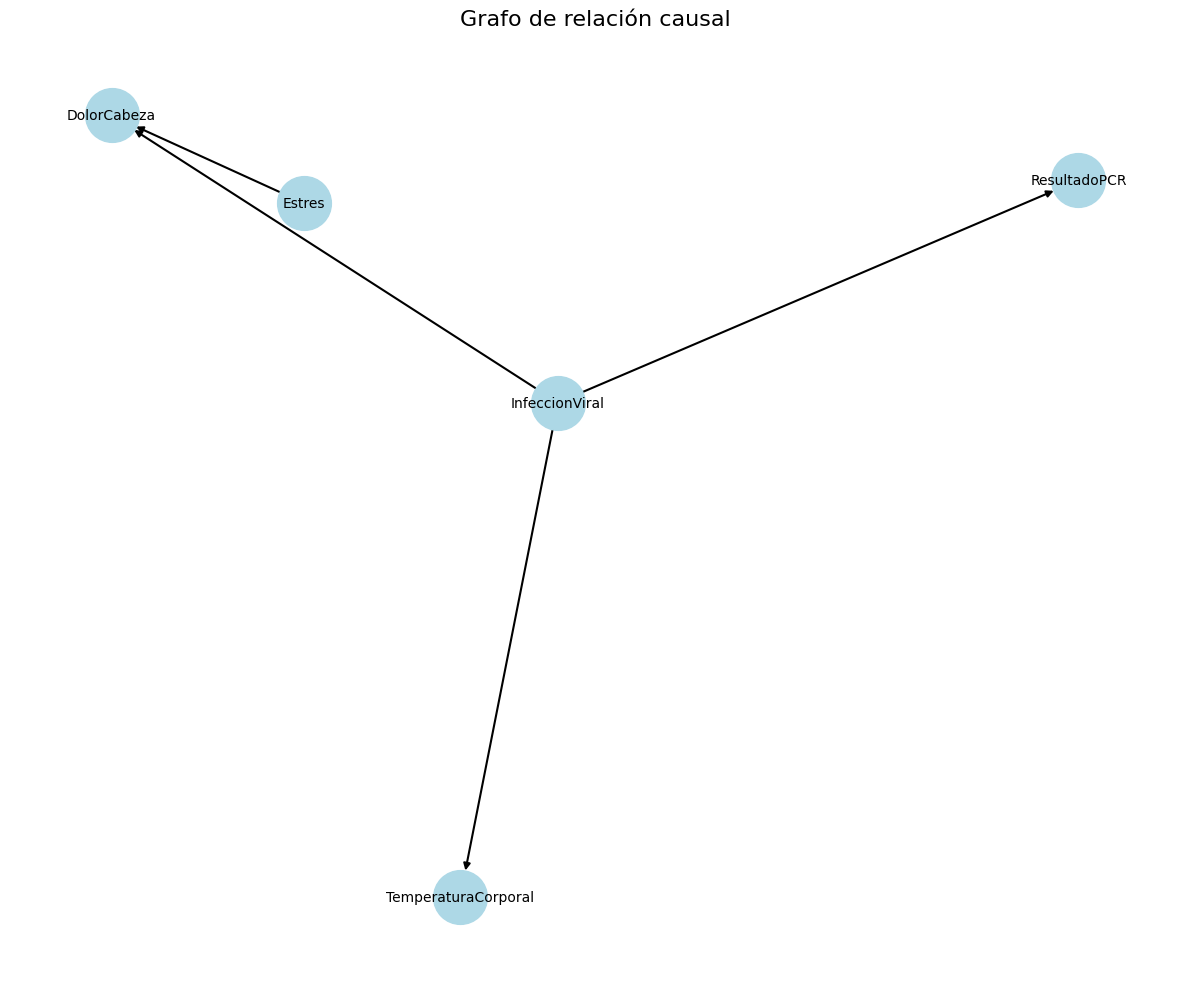

In [ ]:
# Layout: organiza los nodos automáticamente en forma más legible
pos = nx.spring_layout(G_, seed=42)  # Puedes ajustar el seed para cambiar la disposición

# Parámetros
node_size = 1500

# Figura
plt.figure(figsize=(12, 10))
plt.title('Grafo de relación causal', fontsize=16)

nx.draw(
    G_,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color='lightblue',
    font_size= 10,
    font_color='black',
    edge_color='black',
    linewidths=1,
    width=1.5,
    arrows=True
)

plt.axis('off')
plt.tight_layout()
plt.savefig('grafo_causal.png')
plt.show()


## Independencia condicional

Dos variables $X$ e $Y$ se consideran condicionalmente independientes dado un conjunto $Z$, denotado $X \perp\!\!\!\perp Y \mid Z$, si el conocimiento de $Z$ bloquea toda asociación entre ellas.

**Test Z de Fisher**  
Se utiliza para variables continuas bajo el supuesto de distribución normal multivariada. Evalúa si la correlación parcial $r_{XY \cdot Z}$ es significativamente distinta de cero.

$$
Z_f = \sqrt{n - |Z| - 3} \cdot \frac{1}{2} \ln\left(\frac{1 + r_{XY \cdot Z}}{1 - r_{XY \cdot Z}}\right)
$$

El valor $Z_f$ se compara con una distribución normal estándar para obtener un p-value. Si el p-value es mayor que un umbral, se considera que $X$ e $Y$ son independientes dado $Z$.

In [ ]:
from scipy.stats import norm

def fisher_z_test(X, Y, Z=None, data=None):
    """
    Test Z de Fisher para independencia condicional.
    Solo para variables continuas.
    """
    from sklearn.linear_model import LinearRegression

    def partial_corr(x, y, z):
        if z.size == 0:
            return np.corrcoef(x, y)[0, 1]
        lr_x = LinearRegression().fit(z, x)
        lr_y = LinearRegression().fit(z, y)
        res_x = x - lr_x.predict(z)
        res_y = y - lr_y.predict(z)
        return np.corrcoef(res_x, res_y)[0, 1]

    x = data[X].values
    y = data[Y].values

    if Z:
        z = data[Z].values
    else:
        z = np.empty((len(x), 0))

    r = partial_corr(x, y, z)
    n = len(x)

    if abs(r) >= 1:
        return {'z': np.inf, 'p': 0.0}

    z_score = 0.5 * np.log((1 + r) / (1 - r)) * np.sqrt(n - z.shape[1] - 3)
    p = 2 * (1 - norm.cdf(abs(z_score)))
    # P-Value para distribución normal
    return {'z': z_score, 'p': p}

In [ ]:
from itertools import combinations

def test_independencias(data, alpha=0.05, max_cond_set=2):
    variables = list(data.columns)
    resultados = []

    for X, Y in combinations(variables, 2):
    ## Combinaciones de todas las variables probando respectiva independencia causal
        otras = [v for v in variables if v not in [X, Y]]

        # Conjuntos de condicionamiento
        for k in range(0, min(len(otras), max_cond_set) + 1):
            for Z in combinations(otras, k):
                resultado = fisher_z_test(X, Y, Z=list(Z), data=data)
                if resultado['p'] > alpha:
                    resultados.append((X, Y, list(Z), resultado['p']))

    return resultados

# Prueba de hipotesis.
Para concluir si hay independencia lineal de un conjunto de variables x,y dado z, se emplea la siguiente prueba de hipotesis basada en valor $Z_{f}$ del test de Fisher, esto es,
\begin{equation}
\begin{cases}
H_{o}: (X \perp\!\!\!\perp Y \mid Z)_P\\
H_{a}: (X \not \perp\!\!\!\not\perp Y \mid Z)_P
\end{cases}
\end{equation}
En ese caso, cuando $p>\alpha$ siendo $\alpha$ el nivel de significancia, tendriamos que se acepta la hipotesis nula. En dado caso que $p<\alpha$ se rechaza la hipotesis nula y se acepta la hipotesis alternativa. Es decir, que no son condicionalmente independientes dado el valor de la variable Z

In [ ]:
independencias = test_independencias(df, alpha=0.06, max_cond_set=3)

for x, y, z, p in independencias:
    cond = f" | {', '.join(z)}" if z else ""
    print(f"{x} ⫫ {y}{cond}   (p = {p:.3f})")

InfeccionViral ⫫ Estres   (p = 0.118)
InfeccionViral ⫫ Estres | TemperaturaCorporal   (p = 0.259)
InfeccionViral ⫫ Estres | ResultadoPCR   (p = 0.524)
InfeccionViral ⫫ Estres | TemperaturaCorporal, ResultadoPCR   (p = 0.404)
Estres ⫫ TemperaturaCorporal   (p = 0.219)
Estres ⫫ TemperaturaCorporal | InfeccionViral   (p = 0.559)
Estres ⫫ TemperaturaCorporal | ResultadoPCR   (p = 0.830)
Estres ⫫ TemperaturaCorporal | InfeccionViral, DolorCabeza   (p = 0.766)
Estres ⫫ TemperaturaCorporal | InfeccionViral, ResultadoPCR   (p = 0.562)
Estres ⫫ TemperaturaCorporal | InfeccionViral, DolorCabeza, ResultadoPCR   (p = 0.767)
Estres ⫫ ResultadoPCR   (p = 0.138)
Estres ⫫ ResultadoPCR | InfeccionViral   (p = 0.686)
Estres ⫫ ResultadoPCR | TemperaturaCorporal   (p = 0.391)
Estres ⫫ ResultadoPCR | InfeccionViral, TemperaturaCorporal   (p = 0.691)
Estres ⫫ ResultadoPCR | InfeccionViral, DolorCabeza   (p = 0.984)
Estres ⫫ ResultadoPCR | InfeccionViral, TemperaturaCorporal, DolorCabeza   (p = 0.987)
Temper

## Esqueleto grafo causal

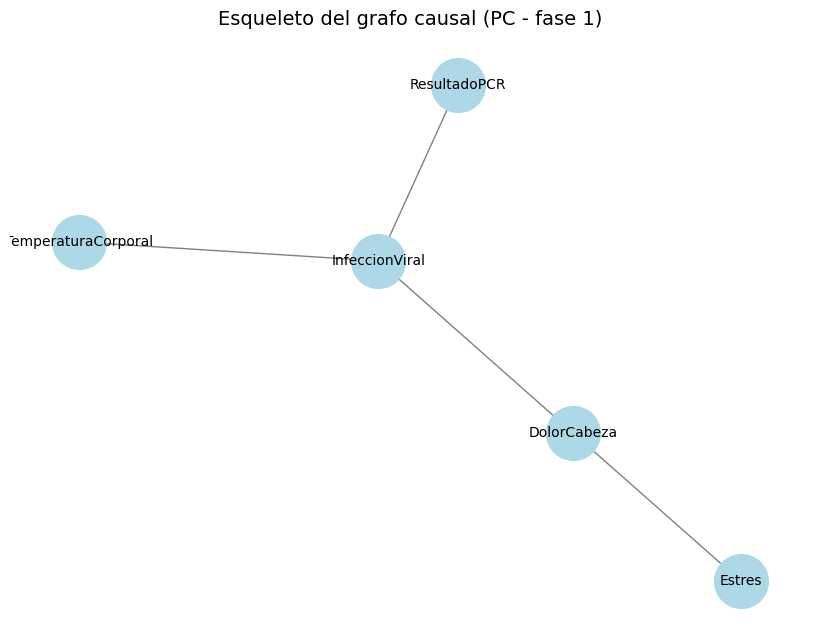

In [ ]:
import networkx as nx

def construir_esqueleto(data, independencias):
    G = nx.complete_graph(data.columns)
    G = nx.Graph(G)  # elimina direcciones

    for x, y, _, _ in independencias:
        if G.has_edge(x, y):
            G.remove_edge(x, y)

    return G

# Construimos el grafo
esqueleto = construir_esqueleto(df, independencias)

# Dibujamos
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(esqueleto, seed=42)  # disposición ordenada
nx.draw(esqueleto, pos, with_labels=True, node_color='lightblue', node_size=1500, edge_color='gray', font_size=10)
plt.title("Esqueleto del grafo causal (PC - fase 1)", fontsize=14)
plt.show()

## Orientación en el algoritmo PC

Una vez construido el esqueleto del grafo, el siguiente paso del algoritmo PC consiste en orientar las aristas para obtener un grafo acíclico parcialmente dirigido (CPDAG).

### 1. Identificación de coliders

Si se detecta un triplete de nodos `A - C - B` tal que:

- `A` y `B` no están conectados en el grafo,
- y `A ⫫ B | S` con `C ∉ S`
entonces se orienta como un **collider**:

A → C ← B

### 2. Reglas de orientación

- **Evitar ciclos:** Solo se permiten orientaciones que mantengan el grafo acíclico.

- **Propagación por adyacencia:** Si `A → B — C` y no hay conexión entre `A` y `C`, se orienta `B — C` como `B → C` para evitar la creación de un nuevo collider no justificado.

- **Orientación forzada por convergencia común:** Si `A — B`, `A — C`, `B → D`, `C → D` y `B` y `C` no están conectados, se orienta `A → B` y `A → C`.

In [ ]:
!pip install causal-learn

  0%|          | 0/5 [00:00<?, ?it/s]

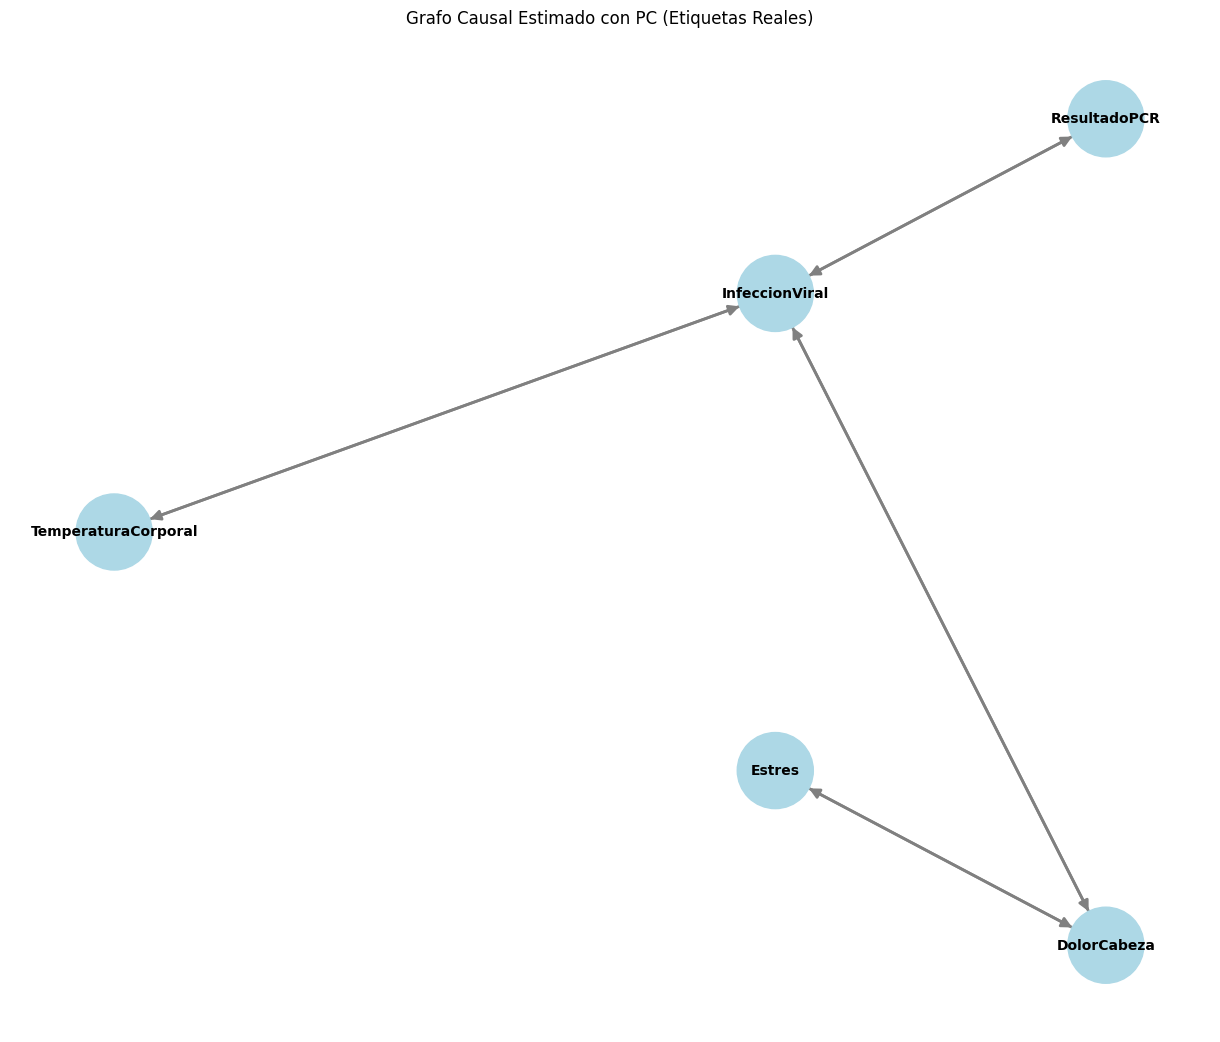

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

# Correr el algoritmo PC (sin return_type='adjacency_matrix')
pc_result = pc(df.to_numpy(), alpha=0.06, indep_test='fisherz')

G_raw = nx.DiGraph(pc_result.G.graph)

G = nx.relabel_nodes(G_raw, mapping={i: name for i, name in enumerate(df.columns)})

all_nodes = list(G.nodes())
mid = len(all_nodes) // 2
shells = [all_nodes[:mid], all_nodes[mid:]]
pos = nx.shell_layout(G, nlist=shells)

node_colors = ['lightblue' for _ in G.nodes()]
node_sizes = [3000 for _ in G.nodes()]
edge_colors = ['gray' for _ in G.edges()]

plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    with_labels=True,
    labels={node: node for node in G.nodes()},
    node_color=node_colors,
    node_size=node_sizes,
    font_size=10,
    font_weight='bold',
    arrowsize=15,
    edge_color=edge_colors,
    width=2
)
plt.title('Grafo Causal Estimado con PC (Etiquetas Reales)')
plt.show()

In [ ]:
pip install causaldag

# **ENTRENAMIENTO**

En esta primera parte del entrenamiento antes de la implementación de las CGNs y GATs, consistió en un pequeño analisis de los datos: se consideró la obtención de 5 grafos observacionalmente equivalentes empleando la libreria causaldag.

Esto se descartó posteriormente dado que la librería causaldag es una libreria que no es activa. Pero, sirvio como base para la busqueda de las GNNs (por eso
no lo quito), puesto que cuando se intentó plantear como entrenar un modelo de aprendizaje estadistico se tuvo el problema que no se sabia como entregarle los datos a un modelo. La respuesta a este problema fue la implementación de las GNNs.



In [ ]:
import causaldag as cd
pc_matrix = pc_result.G.graph

In [ ]:
amat = np.zeros(np.shape(pc_matrix))

In [ ]:
amat[pc_matrix == -1] = 2          # sin orientación
amat[pc_matrix ==  1] = 1

In [ ]:
pdag = cd.PDAG.from_amat(amat) # documentación: https://causaldag-readthedocs-io.translate.goog/en/latest/classes/PDAG.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc#overview

In [ ]:
dags = list(pdag.all_dags())       # lista de cd.DAG
dags_name = list() ## Lista con los nombres de las variables

for i in range(len(dags)):
  dags_name1 = list()
  for k in range(len(dags[i])):
    x1,x2 = list(dags[i])[k]
    labels = ( df.columns[int(x1)], df.columns[int(x2)] )
    dags_name1.append(labels)
  dags_name.append(dags_name1)
print(f"{len(dags)} DAGs equivalentes")

5 DAGs equivalentes


In [ ]:
# Creación de los grafos equivalentes

all = list()

digrafo1 = nx.DiGraph(list(dags_name[0]))
ad_matrix1 = nx.to_pandas_adjacency(digrafo1, nodelist = G_.nodes)
nodes = list(G_.nodes)
DAG1 = cd.DAG.from_amat(ad_matrix1.to_numpy())
all.append(ad_matrix1)
# Matriz de adyacencia
digrafo2 = nx.DiGraph(list(dags_name[1]))
ad_matrix2 = nx.to_pandas_adjacency(digrafo2, nodelist = G_.nodes)
DAG2 = cd.DAG.from_amat(ad_matrix2.to_numpy())
all.append(ad_matrix2)

digrafo3 = nx.DiGraph(list(dags_name[2]))
ad_matrix3 = nx.to_pandas_adjacency(digrafo3, nodelist = G_.nodes)
DAG3 = cd.DAG.from_amat(ad_matrix3.to_numpy())
all.append(ad_matrix3)

digrafo4 = nx.DiGraph(list(dags_name[3]))
ad_matrix4 = nx.to_pandas_adjacency(digrafo4, nodelist = G_.nodes)
DAG4 = cd.DAG.from_amat(ad_matrix4.to_numpy())
all.append(ad_matrix4)

digrafo5 = nx.DiGraph(list(dags_name[4]))
ad_matrix5 = nx.to_pandas_adjacency(digrafo5, nodelist = G_.nodes)
DAG5 = cd.DAG.from_amat(ad_matrix5.to_numpy())
all.append(ad_matrix5)

In [ ]:
ad_matrix1

InfeccionViral  Estres  TemperaturaCorporal  DolorCabeza  \
InfeccionViral                  0.0     0.0                  0.0          1.0   
Estres                          0.0     0.0                  0.0          0.0   
TemperaturaCorporal             1.0     0.0                  0.0          0.0   
DolorCabeza                     0.0     1.0                  0.0          0.0   
ResultadoPCR                    0.0     0.0                  0.0          0.0   

                     ResultadoPCR  
InfeccionViral                1.0  
Estres                        0.0  
TemperaturaCorporal           0.0  
DolorCabeza                   0.0  
ResultadoPCR                  0.0

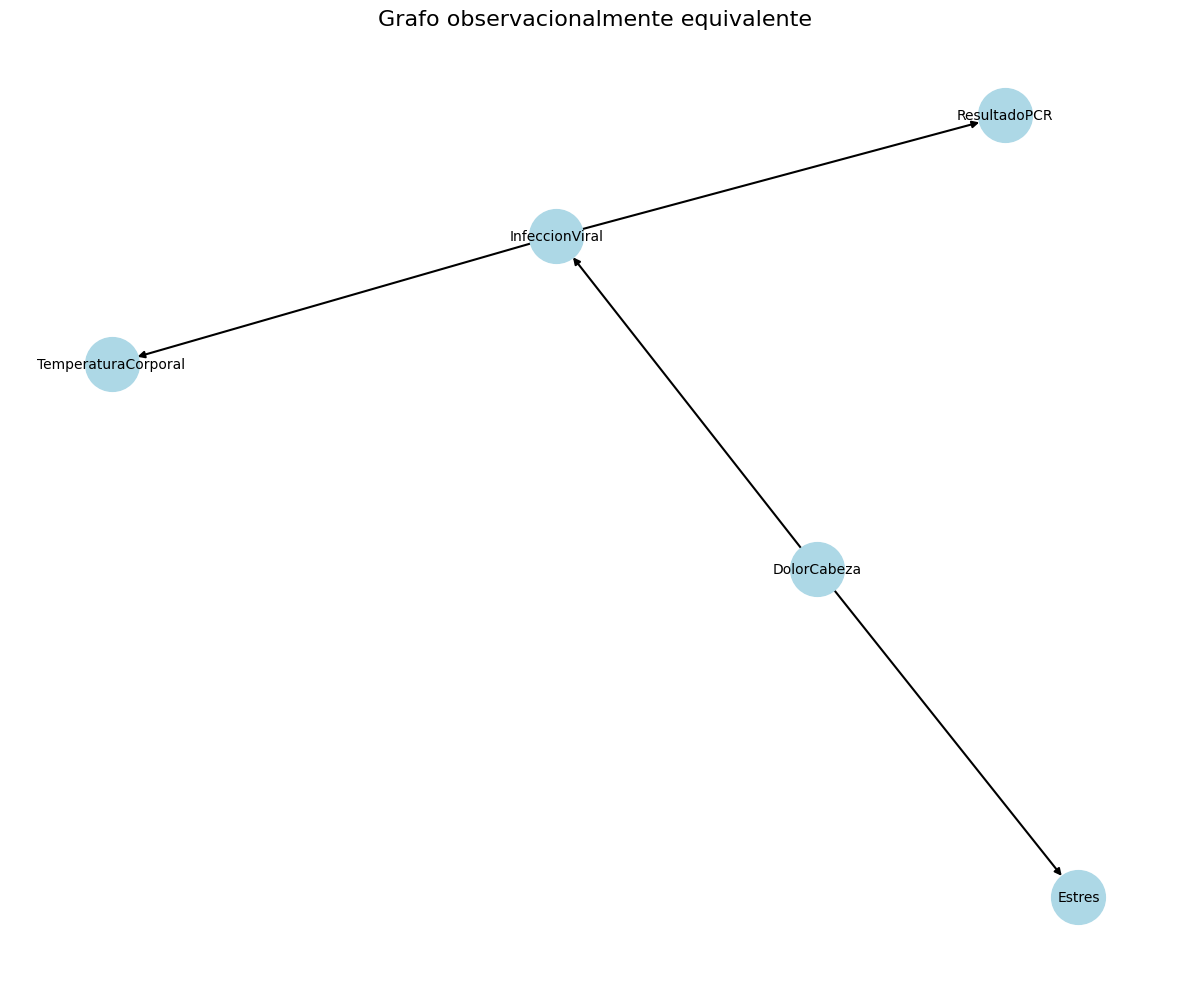

In [ ]:
pos1 = nx.spring_layout(digrafo3, seed=42)
# Parámetros
node_size = 1500
plt.figure(figsize = (12,10))
plt.title('Grafo observacionalmente equivalente', fontsize=16)

nx.draw(
    digrafo3,
    pos1,
    with_labels=True,
    node_size=node_size,
    node_color='lightblue',
    font_size= 10,
    font_color='black',
    edge_color='black',
    linewidths=1,
    width=1.5,
    arrows=True
)

plt.axis('off')
plt.tight_layout()
plt.savefig('grafo_equiv.png')
plt.show()

In [ ]:
### Entrenamiento

### Orientación con probabilidades simples:

DF = nx.to_pandas_adjacency(G_)

## Dimensiones a evaluar
n,m = np.shape(DF.to_numpy())

DolorCabeza = np.zeros((n,m)) ### Las filas corresponden al dato de entramiento
Estres = np.zeros((n,m)) ### Las columnas indican si hay conexión
TemperaturaCorporal = np.zeros((n,m))
ResultadoPCR = np.zeros((n,m))
InfeccionViral = np.zeros((n,m))
Resultado = np.zeros((n,m))

for i in range(len(all)):
  # Acceder a todos los elementos
  datos = all[i]
  variables = datos.index
  columnas = datos.columns
  for q in range(len(variables)):
    for k in range(len(columnas)):
      if datos[variables[q]][columnas[k]] == 1:
        if variables[q] == 'InfeccionViral':
          InfeccionViral[q,k] = 1
        elif variables[q] == 'Estres':
          Estres[q,k] = 1
        elif variables[q] == 'TemperaturaCorporal':
          TemperaturaCorporal[q,k] = 1
        elif variables[q] == 'DolorCabeza':
          DolorCabeza[q,k] = 1
        elif variables[q] == 'ResultadoPCR':
          ResultadoPCR[q,k] = 1
      else:
        pass


for i in range(n):
  for j in range(m):
    if i == 0:
      Resultado[i,j] = np.sum(InfeccionViral[:,j]) / n
    elif i == 1:
      Resultado[i,j] = np.sum(Estres[:,j]) / n
    elif i == 2:
      Resultado[i,j] = np.sum(TemperaturaCorporal[:,j]) / n
    elif i == 3:
      Resultado[i,j] = np.sum(DolorCabeza[:,j]) / n
    elif i == 4:
      Resultado[i,j] = np.sum(ResultadoPCR[:,j]) / n


Esta matriz (Resultados, vease codigo abajo) de los pesos de conexión fue una propuesta realizada por el profesor Hernan para poder asignarle un peso probabilistico para la conexión entre dos variables dadas.

Aquella matriz de resultado consiste en la probabilidad que hubiera una conexión del nodo i al nodo j, teniendo en cuenta que los nodos i serían las filas y los nodos j serían las columnas.

Entonces lease la información del siguiente modo:
La entrada (4,1) indica que teniendo en cuenta unicamente los 5 grafos observacionalmente equivalente existe una probabilidad de 0.2 que haya una conexión en la dirección $4\rightarrow 1$, esto es: $DolorCabeza\rightarrow InfecciónViral$

In [ ]:
Resultado ## Matriz de los pesos de conexión

array([[0. , 0. , 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0.2, 0. ],
       [0.2, 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. ]])

In [ ]:

def comparacion(df_equivalente, df_verdadero):
    data = []
    variables = list(df_equivalente.columns)

    for var1, var2 in itertools.permutations(variables, 2):
        feat = {
            'var1': var1,
            'var2': var2,
            'conectado': df_equivalente.loc[var1, var2], ## como se conecta en el dataframe particular.
        }

        # Orientación real según grafo verdadero
        if df_verdadero.loc[var1, var2] == 1:
            target = 1  # var1 → var2
        else:
            target = 0  # Sin conexión

        feat['target'] = target
        data.append(feat)

    return pd.DataFrame(data)

# Dataset para un grafo equivalente
COMPARACIONES = list()
for dataset in all:
  eval = comparacion(dataset, DF)
  COMPARACIONES.append(eval)


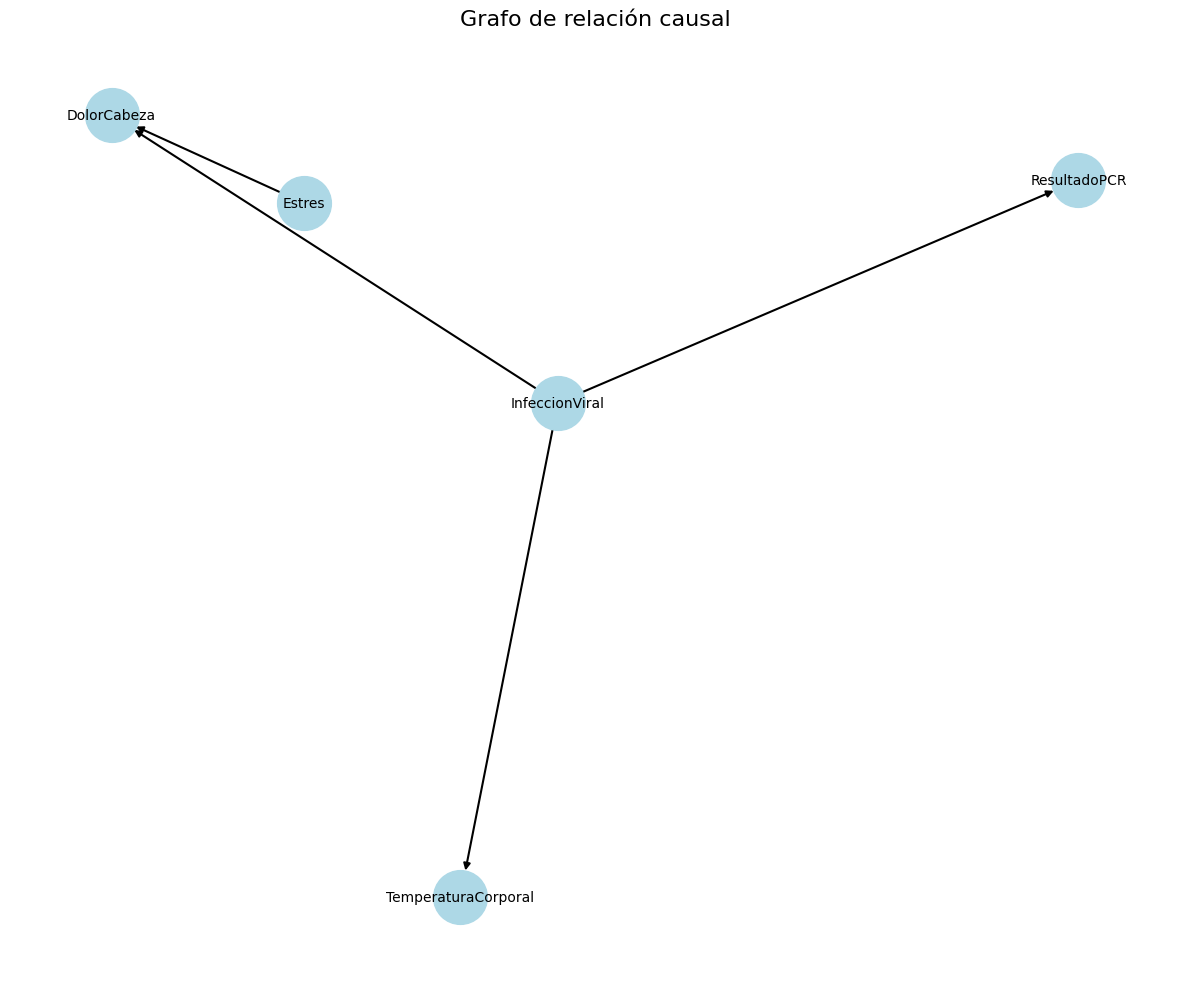

In [ ]:
# Layout: organiza los nodos automáticamente en forma más legible
pos = nx.spring_layout(G_, seed=42)  # Puedes ajustar el seed para cambiar la disposición

# Parámetros
node_size = 1500

# Figura
plt.figure(figsize=(12, 10))
plt.title('Grafo de relación causal', fontsize=16)

nx.draw(
    G_,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color='lightblue',
    font_size= 10,
    font_color='black',
    edge_color='black',
    linewidths=1,
    width=1.5,
    arrows=True
)

plt.axis('off')
plt.tight_layout()
plt.savefig('grafo_causal.png')
plt.show()

# Implementación de las GNNs.
En esta sección se veran implementacioneas de las graph neuronal networks. Esta implementación se realiza empleando la librería torch.

La primera red neuronal grafica que se implementa son las GCN, es decir, las redes graficas convulsionales. Posteriormente se implementa las GAT, que son las redes neuronales graficas de atención.

In [ ]:
## implementación de GNNs.
!pip install -q torch
!pip install torch_geometric

In [ ]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform = NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


# Clasificación de los nodos.
## Implementación sencilla de las GCN

Este problema emplea la base de datos Cora, el cual consiste en 7 tipos de clases, donde cada clase corresponde a un tipo de tema de interes de un articulo. Luego, cada nodo cuenta con un vector de caracteristicas que corresponde a palabras que se encuentran en el articulo. También se realiza una conexión con otro articulo cuando hay una citación entre ambos articulos, entonces estó me va a clasificar el tema de cada nodo para un grafo de entrada

**Referencia:** https://www.datacamp.com/es/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
import numpy as np

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self,x,edge_index):
      X = self.conv1(x, edge_index)
      X = X.relu()
      X = F.dropout(X, p=0.5, training = self.training)
      X = self.conv2(X, edge_index)
      return X

model = GCN(hidden_channels=16)
print(model) ### Arquitectura de la red


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# una visualización sencilla de los datos, donde aquella se le disminuye la dimensionalidad a los datos

NameError: name 'model' is not defined

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9351
Epoch: 004, Loss: 1.9291
Epoch: 005, Loss: 1.9214
Epoch: 006, Loss: 1.9151
Epoch: 007, Loss: 1.9055
Epoch: 008, Loss: 1.8978
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8769
Epoch: 011, Loss: 1.8684
Epoch: 012, Loss: 1.8598
Epoch: 013, Loss: 1.8505
Epoch: 014, Loss: 1.8459
Epoch: 015, Loss: 1.8276
Epoch: 016, Loss: 1.8214
Epoch: 017, Loss: 1.8033
Epoch: 018, Loss: 1.7914
Epoch: 019, Loss: 1.7905
Epoch: 020, Loss: 1.7760
Epoch: 021, Loss: 1.7688
Epoch: 022, Loss: 1.7338
Epoch: 023, Loss: 1.7234
Epoch: 024, Loss: 1.6937
Epoch: 025, Loss: 1.6972
Epoch: 026, Loss: 1.6778
Epoch: 027, Loss: 1.6697
Epoch: 028, Loss: 1.6445
Epoch: 029, Loss: 1.6269
Epoch: 030, Loss: 1.6204
Epoch: 031, Loss: 1.5859
Epoch: 032, Loss: 1.5751
Epoch: 033, Loss: 1.5629
Epoch: 034, Loss: 1.5522
Epoch: 035, Loss: 1.5046
Epoch: 036, Loss: 1.4897
Epoch: 037, Loss: 1.4730
Epoch: 038, Loss: 1.4604
Epoch: 039, Loss: 1.4494
Epoch: 040, Loss: 1.4216


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


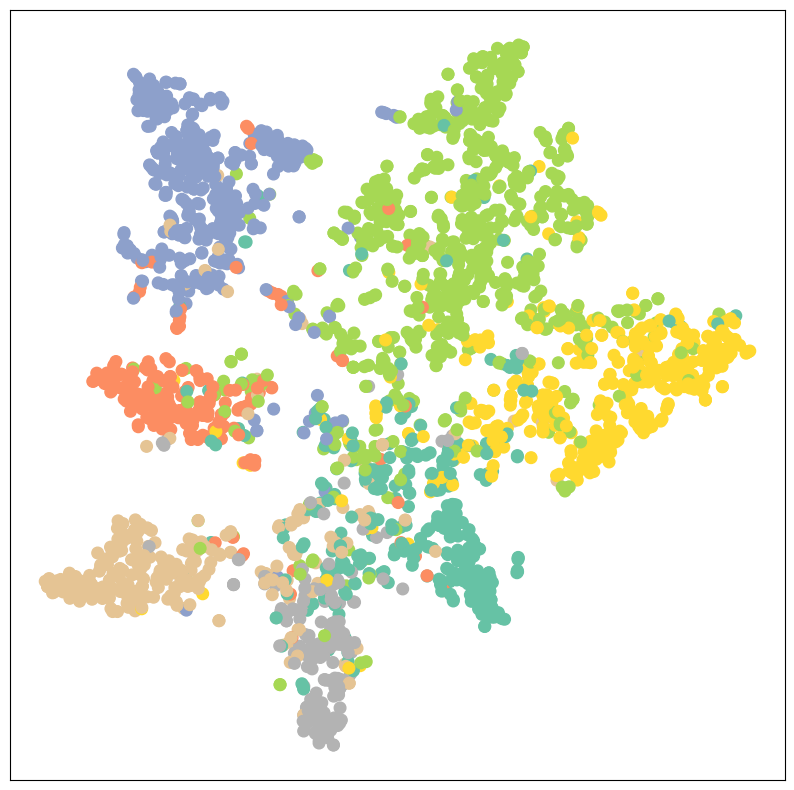

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Implementación de las GAT
En esta sección indico como es una implementación de las GAT, para ello vamos a emplear el mismo dataset anterior, además de realizar la programación de la clase desde cero.

Para implementar los grafos graficos de atención existen diversas librerias que lo contiene. Entre ellas se exploró la librería pytorch y dgl. De hecho, se trabaja en conjunto con ambas librerias.
Esto supuso un problema, porque la libreria dgl fue instaurada en 2018 cuando se presentó en un articulo todo este algoritmo de las GAT.

Pasando por varias versiones, pero la libreria pytorch ha ganado popularidad ultimamente, la cual ha tenido muchas actualizaciones, lo que produjo un problema, ya que la versión instalada en la maquina de google coolab es la versión 2.8, que es inconsistente con la versión de dgl, entonces para implementar ambas librerias se tiene que bajar pytorch a su versión 2.2, además de reinstalar una versión más antigua de numpy.

Así que cuando se corra este documento se debe tener cuidado con aquella versión de torch, anteriormente se instala torch y torch_geometric para la implementación de las CGNs, así que se debe tener cuidado. Recomiendo eliminar el entorno de ejecución y empezar a correr el codigo a partir de está celda.

También recomiendo que cuando la instalación de todas las librerias termine se reinicie la consola:
Entorno de ejecución>>>Reiniciar la sesión

**Referencia:**
* https://www.dgl.ai/blog/2019/02/17/gat.html
* https://www.dgl.ai/dgl_docs/en/2.0.x/tutorials/models/1_gnn/9_gat.html
* Paper GAT: https://arxiv.org/pdf/1710.10903

In [ ]:
!pip install torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2+cu121 -f https://download.pytorch.org/whl/torch_stable.html
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.2/cu121/repo.html
!pip install torchdata

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import torch_geometric
import time
import numpy as np

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Ecuaciones de la red neuronal grafica.

El tipo más comun de red neuronal grafica sería la CGN, por sus siglas en ingles convultional graph network, la cual es el analogo de las redes neuronales convulsionales.

Luego, una GAT sería basicamente una CGN pero teniendo en cuenta un peso asociado a la cantidad de información que brinda los vecinos al nodo de interes.

Las ecuaciones que define una red neuronal grafica son:

\begin{equation}
    z_{i}^{(l)}=W^{(l)}h_{i}^{(l)}
\end{equation}

\begin{equation}
    e_{ij}^{(l)}=LeakyReLU(\vec{a}^{(l)^{T}}(z_{i}^{(l)}||z_{j}^{(l)}))
\end{equation}

\begin{equation}
    \alpha_{ij}^{(l)}= \frac{exp(e_{ij}^{(l)})}{\sum_{k \in \mathcal{N}(i)}exp(e_{ik}^{(l)})}
\end{equation}

\begin{equation}
    h_{i}^{(l+1)}=\sigma\left(\sum_{j\in \mathcal{N}(i)}\alpha_{ij}^{(l)}z_{j}^{(l)}\right)
\end{equation}

Ahora los autores Petar Velickovic, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò y Yoshua Bengio recomiendan emplear el modelo de "multiples cabezas", por ello se emplea la siguientes dos ecuaciones para darle mayor capacidad y aprendizaje del modelo:

\begin{equation}
h_{i}^{(l+1)}=||_{k=1}^{K} \sigma \left( \sum_{j\in \mathcal{N}(i)} \alpha_{ij}^{k}W^{k}h_{j}^{(l)}  \right)
\end{equation}

\begin{equation}
h_{i}^{(l+1)}=\sigma \left(\frac{1}{K} \sum_{k=1}^{N}\sum_{j\in \mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h_{j}^{(l)}   \right)
\end{equation}

In [ ]:
# Referencia: https://www.dgl.ai/blog/2019/02/17/gat.html

class GATLayer(nn.Module): # nn.Moudele --base de Pytorch para modelos de redes neuronales


    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__() # inicialización la infraestructura de pytorch
        self.g = g # Grafo que se construye en todo el procedimiento

        # ecuación (1) -- Transformación lineal

        self.fc = nn.Linear(in_dim, out_dim, bias=False)

        # ecuación (2) -- Concatenación de los datos
        # transformación que combina la dimensión de entrada y lo transforma en un vector de salida
        # por la misma dimensión indicada.

        # y = Wx + b, cuando bias = False hace que b = 0.

        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

    def edge_attention(self, edges):
        # Aplicación de la ecuación (2)

        # Concatenación para cada par de nodos con conexión unica
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)

        # Calculo del puntaje de atención
        a = self.attn_fc(z2)

        return {'e' : F.leaky_relu(a)} # Aplicación del leaky_ReLU

    def message_func(self, edges):
        # Mensaje para la ecuación (3) y (4).
        # Esto es un diccionario que estaría indicando la información que manda i → j
        return {'z' : edges.src['z'], 'e' : edges.data['e']}

    def reduce_func(self, nodes):
        # normalización del puntaje de atención ec: (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)

        # nodes.mailbox es un tensor que contiene el vector de caracteristicas de cada nodo
        # donde tiene en cuenta para cada nodo la información de todos los otros nodos de conexión
        # unica, además tiene encuenta también todos los pesos asociados a esa información

        # ecuacion (4) salida de la capa
        # suma ponderada de la información mandanda con su respectivo peso
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h' : h}

    def forward(self, h):
        # forward pass de toda la red

        # Ecuacion (1) -- transformación lineal de la salida de la capa
        z = self.fc(h)

        # caracteristicas de cada nodo en el grafo
        self.g.ndata['z'] = z

        # ecuación (2)

        # puntajes de atención para cada una de las aristas (i,j) del grafo
        self.g.apply_edges(self.edge_attention)

        # ecuación (3) y (4)
        # entrega de mensaje, normalización y calculo de la información ponderada
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__() # inicialización la infraestructura de pytorch
        self.heads = nn.ModuleList() ## lista especial de pytorch
        for i in range(num_heads):
          self.heads.append(GATLayer(g, in_dim, out_dim)) ## Agregar en una lista todas las cabezas obtenidas anteriormente
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        # tipo de combinación de cada una de las cabezas obtenidas

        if self.merge == 'cat':
            # concatenar todas las cabezas de salida
            return torch.cat(head_outs, dim=1)
        else:
            # promediar
            return torch.mean(torch.stack(head_outs)) # torch.stack(head_outs) apila una lista en un tensor

## Teniendo en cuenta estas dos clases se define la siguiente clase para el modelo completo

class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads) # varias cabezas concatenado
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1) # única cabeza de salida

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h) # función de activación no lineal (exponencial linear unit)
        h = self.layer2(h)
        return h


In [ ]:
import dgl
import torch
from dgl.data import CoraGraphDataset

def load_cora_data():
    dataset = CoraGraphDataset()
    g = dataset[0] # grafo

    features = g.ndata['feat']        # vector de características
    labels = g.ndata['label']         # etiquetas
    train_mask = g.ndata['train_mask']  # máscara de entrenamiento
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']

    return g, features, labels, train_mask, val_mask, test_mask


In [ ]:
import time
import numpy as np
g, features, labels, train_mask, val_mask, test_mask = load_cora_data()

# Creación del modelo
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=8)
print(net)

# Optimizador (gradiente)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


dur = []
# 30 ciclos de entrenamiento
for epoch in range(30):
    if epoch >=3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), np.mean(dur)))

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
GAT(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0-7): 8 x GATLayer(
        (fc): Linear(in_features=1433, out_features=8, bias=False)
        (attn_fc): Linear(in_features=16, out_features=1, bias=False)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=64, out_features=7, bias=False)
        (attn_fc): Linear(in_features=14, out_features=1, bias=False)
      )
    )
  )
)


/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.9459 | Time(s) nan
Epoch 00001 | Loss 1.9444 | Time(s) nan
Epoch 00002 | Loss 1.9430 | Time(s) nan
Epoch 00003 | Loss 1.9415 | Time(s) 0.3100
Epoch 00004 | Loss 1.9400 | Time(s) 0.3054
Epoch 00005 | Loss 1.9385 | Time(s) 0.3055
Epoch 00006 | Loss 1.9369 | Time(s) 0.3054
Epoch 00007 | Loss 1.9353 | Time(s) 0.4243
Epoch 00008 | Loss 1.9337 | Time(s) 0.4594
Epoch 00009 | Loss 1.9320 | Time(s) 0.5162
Epoch 00010 | Loss 1.9303 | Time(s) 0.5303
Epoch 00011 | Loss 1.9285 | Time(s) 0.5559
Epoch 00012 | Loss 1.9267 | Time(s) 0.5732
Epoch 00013 | Loss 1.9248 | Time(s) 0.5496
Epoch 00014 | Loss 1.9229 | Time(s) 0.5301
Epoch 00015 | Loss 1.9209 | Time(s) 0.5143
Epoch 00016 | Loss 1.9189 | Time(s) 0.4997
Epoch 00017 | Loss 1.9168 | Time(s) 0.4871
Epoch 00018 | Loss 1.9147 | Time(s) 0.4765
Epoch 00019 | Loss 1.9125 | Time(s) 0.4668
Epoch 00020 | Loss 1.9103 | Time(s) 0.4575
Epoch 00021 | Loss 1.9080 | Time(s) 0.4526
Epoch 00022 | Loss 1.9056 | Time(s) 0.4523
Epoch 00023 | Loss 1

In [ ]:
# Implementación de la GAT a nuestro problema inicial de predicción
!pip install causal-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Librerias
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GATConv
from causallearn.search.ConstraintBased.PC import pc


In [ ]:
# Datos del problema
def simulate_df(n=3000, seed=42):
    rng = np.random.default_rng(seed)
    infeccion = rng.binomial(1, 0.4, size=n)
    estres = rng.integers(0, 10, size=n)
    temperatura = 36.5 + 1.5 * infeccion + rng.normal(0, 0.3, size=n)
    dolor_cabeza = (2 + 1.0 * infeccion + 0.5 * estres + rng.normal(0, 1, size=n)).astype(int)
    resultado_pcr = rng.binomial(1, 0.9 * infeccion + 0.1 * (1 - infeccion))

    df = pd.DataFrame({
        'InfeccionViral': infeccion,
        'Estres': estres,
        'TemperaturaCorporal': temperatura,
        'DolorCabeza': dolor_cabeza,
        'ResultadoPCR': resultado_pcr
    })
    return df

nombres = ["InfeccionViral", "Estres", "TemperaturaCorporal", "DolorCabeza", "ResultadoPCR"]

# Matriz VERDADERA en el orden de 'nombres'
A_true = np.array([
    [0., 0., 1., 1., 1.],  # InfeccionViral -> Temp, Dolor, PCR
    [0., 0., 0., 1., 0.],  # Estres -> Dolor
    [0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0.]
], dtype=np.float32)

df_full = simulate_df(n=3000, seed=42)

## Boostraping de los datos

def bootstrap_samples(df, B=300, frac=1.0, seed=123):

    rng = np.random.default_rng(seed) ## Fijar la reproducibilidad del estado aleatorio
    n = len(df)
    samples = []
    for b in range(B):
        idx = rng.integers(0, n, size=int(frac*n))
        samples.append(df.iloc[idx].reset_index(drop=True))
    return samples

boot_dfs = bootstrap_samples(df_full, B=300, frac=1.0, seed=123)

### Obtención de una matriz adyacencia a partir del resultado del PC

def pc_codes_from_df(df, alpha=0.06):
    """
    Ejecuta PC y devuelve una matriz NxN con códigos:
       0 = no arista
       1 = arista dirigida i->j
       2 = arista sin orientación (independientemente de la dirección)
    """
    data = df[nombres].to_numpy()  # asegura el orden correcto
    res = pc(data, alpha=alpha, indep_test='fisherz')
    G = res.G.graph
    G = np.asarray(G)
    amat = np.zeros_like(G, dtype=np.int64)
    amat[G == -1] = 2
    amat[G ==  1] = 1
    return amat

# Grafo parcialmente dirigido obtenido por el algoritmo PC

def skeleton_from_pc_codes(amat_codes):
    """
    Devuelve el 'esqueleto' no dirigido. Hay arista si:
      - amat_codes[i,j] == 1 (i->j) o amat_codes[j,i] == 1
      - o amat_codes[i,j] == 2 (sin orientación) o amat_codes[j,i] == 2
    """
    A = ( (amat_codes == 1).astype(int) + (amat_codes.T == 1).astype(int) +
          (amat_codes == 2).astype(int) + (amat_codes.T == 2).astype(int) )
    A = (A > 0).astype(np.int64)
    np.fill_diagonal(A, 0)
    return A  # binaria 0/1

# Construcción de grafo dgl a partir del algoritmo PC

def dgl_graph_from_skeleton(A_skel):
    """
    Construye un grafo dirigido en DGL añadiendo ambas direcciones
    para cada arista del esqueleto (vecindad no dirigida).
    """
    src, dst = np.where(A_skel == 1)
    g = dgl.graph((src, dst), num_nodes = A_skel.shape[0])
    return g

## Caracteristicas del nodo a partir del dataframe

def node_features_from_df(df, nombres):
    feats = []
    for col in nombres:
        x = df[col].values.astype(np.float32)
        feats.append([float(np.mean(x)), float(np.std(x))])
    return torch.tensor(feats, dtype=torch.float32)

## Etiqueta para las conexiones entre las variables

def edge_pairs_and_labels_from_true(A_skel, A_true):
    """
    Para cada par (u,v) con A_skel[u,v]==1 y u<v, genera una etiqueta binaria:
      y=0 si la dirección verdadera es u->v
      y=1 si la dirección verdadera es v->u
    Si en A_true no hay arista entre u y v, se descarta.
    """
    N = A_skel.shape[0]
    u_idx, v_idx, y = [], [], []
    for u in range(N):
        for v in range(u+1, N):
            if A_skel[u, v] == 1:
                if A_true[u, v] == 1 and A_true[v, u] == 0:
                    u_idx.append(u); v_idx.append(v); y.append(0)
                elif A_true[v, u] == 1 and A_true[u, v] == 0:
                    u_idx.append(u); v_idx.append(v); y.append(1)
                else:
                    # sin arista en el verdadero -> ignoro este par
                    pass
    if len(y) == 0:
        return None
    return (torch.tensor(u_idx, dtype=torch.long),
            torch.tensor(v_idx, dtype=torch.long),
            torch.tensor(y, dtype=torch.long))


In [ ]:
## Modelo GAT

class GATEncoder(nn.Module):
    def __init__(self, in_dim=2, hid_dim=8, num_heads=2, out_dim=16):
        super().__init__()
        self.gat1 = GATConv(in_dim, hid_dim, num_heads=num_heads, feat_drop=0.0, attn_drop=0.0, activation=F.elu)
        self.gat2 = GATConv(hid_dim*num_heads, out_dim, num_heads=1, feat_drop=0.0, attn_drop=0.0, activation=None)

    def forward(self, g, x):
        h = self.gat1(g, x)       # [N, num_heads, hid_dim]
        h = h.flatten(1)          # [N, hid_dim*num_heads]
        h = self.gat2(g, h)       # [N, 1, out_dim]
        h = h.squeeze(1)          # [N, out_dim]
        return h

class EdgeOrienter(nn.Module):
    def __init__(self, emb_dim=16, hidden=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2*emb_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, H, u, v):
        Hu, Hv = H[u], H[v]
        x = torch.cat([Hu, Hv], dim=1)   # [E, 2*emb_dim]
        return self.mlp(x)               # [E, 2]



In [ ]:
## Preparación de los elementos de entrenamiento:

def build_training_items(boot_dfs, A_true):
    items = []  # lista de (g, features, edge_u, edge_v, y)
    for df in boot_dfs:
        codes = pc_codes_from_df(df)                 # matriz PC
        A_skel = skeleton_from_pc_codes(codes)       # esqueleto binario
        g = dgl_graph_from_skeleton(A_skel)
        feats = node_features_from_df(df, nombres)   # [N,2]
        evy = edge_pairs_and_labels_from_true(A_skel, A_true)
        if evy is None:
            continue
        edge_u, edge_v, y = evy
        items.append((g, feats, edge_u, edge_v, y))
    return items

train_items = build_training_items(boot_dfs, A_true)
assert len(train_items) > 0, "No se generaron ejemplos de entrenamiento; revisa PC/alpha."

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
## Entrenamiento del modelo.

torch.manual_seed(0)
encoder = GATEncoder(in_dim=2, hid_dim=8, num_heads=2, out_dim=16)
head = EdgeOrienter(emb_dim=16, hidden=32)

params = list(encoder.parameters()) + list(head.parameters())
opt = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 50
for epoch in range(1, EPOCHS+1):
    encoder.train(); head.train()
    total_loss, total_edges, correct = 0.0, 0, 0

    for (g, feats, eu, ev, y) in train_items:
        H = encoder(g, feats)          # [N,emb]
        logits = head(H, eu, ev)       # [E,2]
        loss = loss_fn(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * len(y)
        total_edges += len(y)
        with torch.no_grad():
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()

    avg_loss = total_loss / max(total_edges,1)
    acc = correct / max(total_edges,1)
    print(f"Epoch {epoch:03d} | loss {avg_loss:.4f} | acc {acc:.3f}")

Epoch 001 | loss 0.0852 | acc 0.976
Epoch 002 | loss 0.0000 | acc 1.000
Epoch 003 | loss 0.0000 | acc 1.000
Epoch 004 | loss 0.0000 | acc 1.000
Epoch 005 | loss 0.0000 | acc 1.000
Epoch 006 | loss 0.0000 | acc 1.000
Epoch 007 | loss 0.0000 | acc 1.000
Epoch 008 | loss 0.0000 | acc 1.000
Epoch 009 | loss 0.0000 | acc 1.000
Epoch 010 | loss 0.0000 | acc 1.000
Epoch 011 | loss 0.0000 | acc 1.000
Epoch 012 | loss 0.0000 | acc 1.000
Epoch 013 | loss 0.0000 | acc 1.000
Epoch 014 | loss 0.0000 | acc 1.000
Epoch 015 | loss 0.0000 | acc 1.000
Epoch 016 | loss 0.0000 | acc 1.000
Epoch 017 | loss 0.0000 | acc 1.000
Epoch 018 | loss 0.0000 | acc 1.000
Epoch 019 | loss 0.0000 | acc 1.000
Epoch 020 | loss 0.0000 | acc 1.000
Epoch 021 | loss 0.0000 | acc 1.000
Epoch 022 | loss 0.0000 | acc 1.000
Epoch 023 | loss 0.0000 | acc 1.000
Epoch 024 | loss 0.0000 | acc 1.000
Epoch 025 | loss 0.0000 | acc 1.000
Epoch 026 | loss 0.0000 | acc 1.000
Epoch 027 | loss 0.0000 | acc 1.000
Epoch 028 | loss 0.0000 | ac

In [ ]:
codes_full = pc_codes_from_df(df_full)
A_skel_full = skeleton_from_pc_codes(codes_full)
g_full = dgl_graph_from_skeleton(A_skel_full)
feats_full = node_features_from_df(df_full, nombres)

# Pares de aristas a orientar (según esqueleto del PC del df_full)

N = A_skel_full.shape[0]
pairs_u, pairs_v = [], []
for u in range(N):
    for v in range(u+1, N):
        if A_skel_full[u, v] == 1:
            pairs_u.append(u); pairs_v.append(v)

pairs_u = torch.tensor(pairs_u, dtype=torch.long)
pairs_v = torch.tensor(pairs_v, dtype=torch.long)

# Predicción
encoder.eval(); head.eval()

with torch.no_grad():
    H_full = encoder(g_full, feats_full)
    logits_full = head(H_full, pairs_u, pairs_v)
    pred_full = logits_full.argmax(1)  # 0 => u->v, 1 => v->u

# Construimos matriz orientada predicha

A_pred_full = np.zeros_like(A_skel_full, dtype=np.float32)

for (u, v, p) in zip(pairs_u.tolist(), pairs_v.tolist(), pred_full.tolist()):
    if p == 0:
        A_pred_full[u, v] = 1.0
    else:
        A_pred_full[v, u] = 1.0

print("Matriz orientada predicha (sobre df completo):\n", A_pred_full)

  0%|          | 0/5 [00:00<?, ?it/s]

Matriz orientada predicha (sobre df completo):
 [[0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_causal_graph(amat_codes, var_names, title="Grafo de relación causal"):
    """
    Dibuja el grafo dirigido a partir de la matriz de adyacencia.
    - amat_codes[i,j] = 1  -> i -> j
    - amat_codes[i,j] = 2  -> i - j (sin orientación, se muestra como arista no dirigida)
    """

    G_ = nx.DiGraph()

    # Añadir nodos
    for v in var_names:
        G_.add_node(v)

    # Añadir aristas según la codificación
    n = len(var_names)
    for i in range(n):
        for j in range(n):
            if amat_codes[i, j] == 1:   # i -> j
                G_.add_edge(var_names[i], var_names[j])
            elif amat_codes[i, j] == 2 and amat_codes[j, i] == 0:
                # Sin orientación (dibujar como línea no dirigida)
                G_.add_edge(var_names[i], var_names[j])
                G_.add_edge(var_names[j], var_names[i])

    # Layout
    pos = nx.spring_layout(G_, seed=42)

    # Figura
    plt.figure(figsize=(12, 10))
    plt.title(title, fontsize=16)

    nx.draw(
        G_,
        pos,
        with_labels=True,
        node_size=1500,
        node_color='lightblue',
        font_size=10,
        font_color='black',
        edge_color='black',
        linewidths=1,
        width=1.5,
        arrows=True
    )

    plt.axis('off')
    plt.tight_layout()
    plt.savefig("grafo_causal.png")
    plt.show()

    return G_


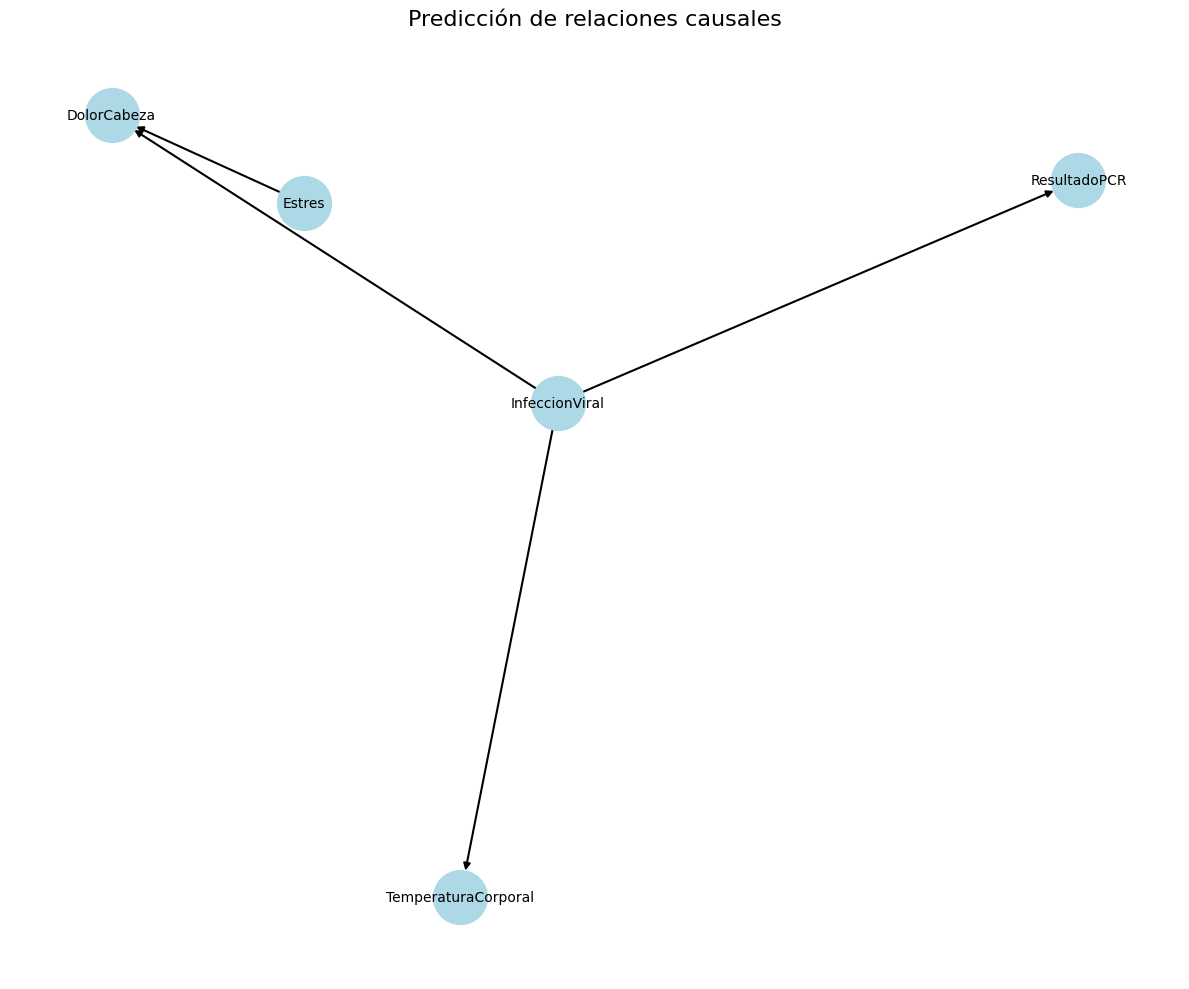

In [ ]:
var_names = ['InfeccionViral', 'Estres', 'TemperaturaCorporal', 'DolorCabeza', 'ResultadoPCR']

# Suponiendo que `amat_final` es tu matriz de predicción obtenida
G_pred = plot_causal_graph(A_pred_full, var_names, title="Predicción de relaciones causales")


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(amat_true, amat_pred, title="Evaluación del modelo"):
    """
    Evalúa el modelo comparando la matriz de adyacencia real vs. predicha.
    amat_true: matriz binaria (0/1) del grafo verdadero (direcciones)
    amat_pred: matriz binaria (0/1) del grafo predicho
    """

    # Convertir a binario

    y_true = (amat_true.flatten() > 0).astype(int)
    y_pred = (amat_pred.flatten() > 0).astype(int)

    # === Matriz de confusión ===
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión - {title}")
    plt.show()

    # === ROC ===
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {title}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return cm, roc_auc


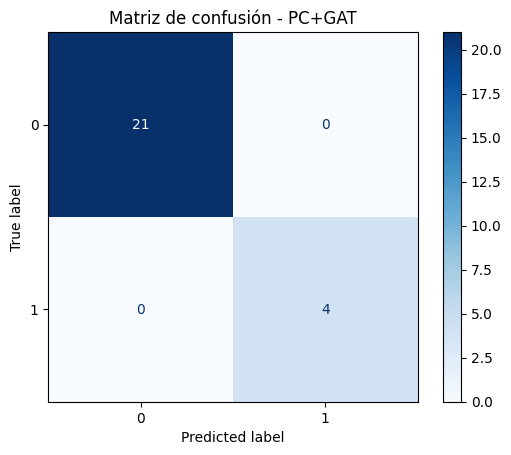

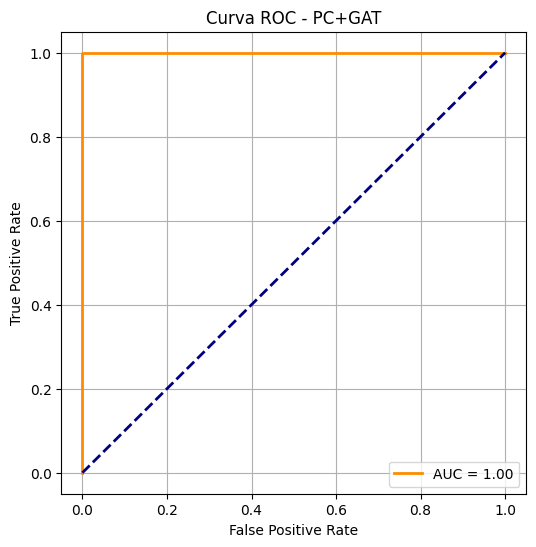

Matriz de confusión:
 [[21  0]
 [ 0  4]]
AUC: 1.0


In [ ]:

cm, roc_auc = evaluate_model(A_true, A_pred_full, title="PC+GAT")
print("Matriz de confusión:\n", cm)
print("AUC:", roc_auc)
